### Details for code ordinances found at https://library.municode.com/az/scottsdale/codes/code_of_ordinances


In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyodbc
import pandas as pd
import seaborn as sns
import datetime
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
code_violations_query = ''' select * from [City_of_Scottsdale].[dbo].[np_CodeViolations] '''

code_violations = pd.read_sql(code_violations_query, connection)
connection.close()

# convert latitude and longitude attributes to numeric from object
# can I combine both of the below lines of code into one?
code_violations['_Latitude_'] = pd.to_numeric(code_violations['_Latitude_'], errors="coerce")
code_violations['_Longitude_'] = pd.to_numeric(code_violations['_Longitude_'], errors="coerce")

# convert date fields from object to datetime format to be able to perform math below
code_violations['_DateComplaintReceived_'] = pd.to_datetime(code_violations['_DateComplaintReceived_'])
code_violations['_DateComplaintClosed_'] = pd.to_datetime(code_violations['_DateComplaintClosed_'])

# find difference between date complaint was received and when it was closed
code_violations['Open_Close_Dif'] = code_violations['_DateComplaintClosed_'] - code_violations['_DateComplaintReceived_']

code_violations['Open_Close_Dif_Days'] = code_violations['Open_Close_Dif']. \
    apply(lambda x: str(x)[-25:-20]) # extract the hour of the day from the datetime column
# citations['Hour_of_Day'] = pd.to_numeric(citations['Hour_of_Day'],errors='coerce')

code_violations['Open_Close_Dif_Days'] = pd.to_numeric(code_violations['Open_Close_Dif_Days'],errors='coerce')


In [48]:
code_violations.head(50)

,_ViolationID_,_ComplaintID_,_DateComplaintReceived_,_DateComplaintClosed_,_ComplaintStatus_,_ViolationCategory_,_ViolationCode_,_StreetNumber_,_StreetDirection_,_StreetName_,_StreetType_,_SuiteApt_,_UnitNumber_,_ZipCode_,_ParcelCode_,_Subdivision_,_LotNumber_,_Latitude_,_Longitude_,Open_Close_Dif,Open_Close_Dif_Days
0,345175,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Administration and Procedures,1.1101,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0
1,345176,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Article VI SUPPLEMENTARY DISTRICTS: Sec...,6.1060.A.1,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0
2,345177,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Native Plant Program,7.501.1.b,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704477,-111.875734,1640 days 22:41:33.774000,1640.0
3,355908,247116,2014-08-11 09:54:15.710,2019-04-09 15:38:13.367,CLOSED-NOV ISSUED,Zoning-Uses Permitted Residential,3.100,8144,E,VIA DONA,RD,,,85266,216-70-005T,,,33.749464,-111.904722,1702 days 05:43:57.657000,1702.0
4,356293,247116,2014-08-11 09:54:15.710,2019-04-09 15:38:13.367,CLOSED-NOV ISSUED,Zoning-Uses Permitted Residential,5.012(A)(R1-190),8144,E,VIA DONA,RD,,,85266,216-70-005T,,,33.749464,-111.904722,1702 days 05:43:57.657000,1702.0
5,384758,270316,2016-03-16 09:20:36.657,2018-06-27 09:06:34.613,CLOSED-NOV ISSUED,Zoning-Uses Permitted Commercial,5.1202(C-S),10433,N,SCOTTSDALE,RD,,,85253,175-33-003A,PARADISE VALLEY PLAZA,3,33.581572,-111.925696,832 days 23:45:57.956000,832.0
6,391371,275416,2016-07-26 12:14:15.183,2018-05-24 09:33:39.900,CLOSED-NOV ISSUED,18-9 LAND,18-9(A)(1) Blight - Bare Lawn,3295,N,DRINKWATER,BL,,,85251,130-21-001F,,,33.485243,-111.922249,666 days 21:19:24.717000,666.0
7,391372,275416,2016-07-26 12:14:15.183,2018-05-24 09:33:39.900,CLOSED-NOV ISSUED,18-9 LAND,18-9(A)(4) Dead/Dry Lawn,3295,N,DRINKWATER,BL,,,85251,130-21-001F,,,33.485243,-111.922249,666 days 21:19:24.717000,666.0
8,394121,276822,2016-08-23 14:24:22.670,2018-06-06 11:41:15.223,CLOSED-NOV ISSUED,Zoning-Administration and Procedures,1.1101,10656,E,WINTER SUN,DR,,,85262,219-60-210,MIRABEL VILLAGE 5,61,33.827081,-111.850573,651 days 21:16:52.553000,651.0
9,394640,270316,2016-03-16 09:20:36.657,2018-06-27 09:06:34.613,CLOSED-NOV ISSUED,18-9 LAND,18-9(A)(4) Uncultivated Growth in Desert Lands...,10433,N,SCOTTSDALE,RD,,,85253,175-33-003A,PARADISE VALLEY PLAZA,3,33.581572,-111.925696,832 days 23:45:57.956000,832.0


In [56]:
# code_violations.info()

In [78]:
code_violations.groupby(['_ViolationCategory_','_ViolationCode_'])['_ViolationCategory_'] \
    .count() \
    .unstack() \
    .loc['Zoning-Native Plant Program'] \
    .dropna()

# Viloation Categories are broken down into more detail by the Violation Code
# For instance, the viloation 'Zoning-Native Plant Program' has 6 unique violation types

_ViolationCode_
7.501.1.b     2.0
7.503.1      10.0
7.503.2       1.0
7.503.3       4.0
7.503.4       2.0
7.504.2       1.0
Name: Zoning-Native Plant Program, dtype: float64

In [96]:
# by a long shot land has the most violations
violation_category = code_violations.groupby('_ViolationCategory_')['_ViolationCategory_'].count().sort_values(ascending=False).head(10)
# type(x)
violation_category

# .index
# .values

_ViolationCategory_
18-9 LAND                                             11277
18-5 PUBLIC NUISANCE                                   2817
18-7 VEHICLES/ WATERCRAFT                               441
Zoning-Sign Requirements                                337
Zoning-Uses Permitted Residential                       196
Zoning-Administration and Procedures                    194
ARS 33-1902 RENTAL REGISTRATION                         128
Zoning-Designated Parking-Front Yards                   126
18-8 BUILDINGS/ STRUCTURES/ ACCESSORY IMPROVEMENTS      119
No Violation                                            118
Name: _ViolationCategory_, dtype: int64

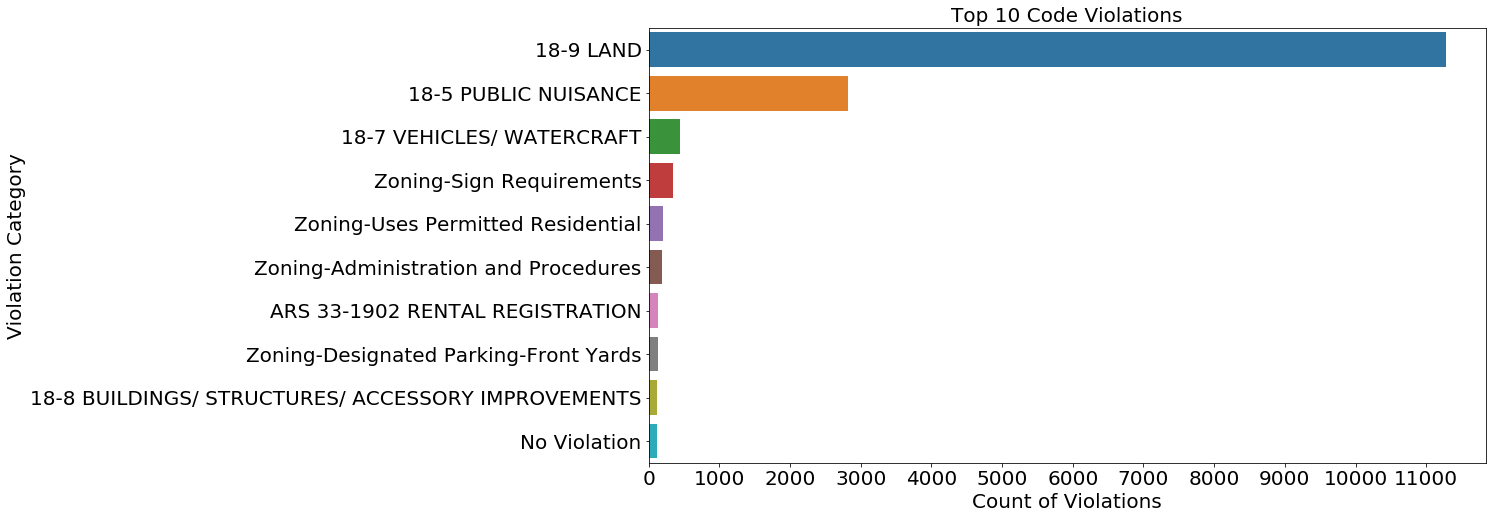

In [118]:
plt.rcParams["figure.figsize"] = [15, 8]

ax = sns.barplot(violation_category.values, violation_category.index)
plt.title('Top 10 Code Violations',fontsize=20)
plt.ylabel('Violation Category',fontsize=20)
plt.xlabel('Count of Violations',fontsize=20)
plt.tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))

In [115]:
# which specific sub-categories within 'Land' have the most violations?
# it seems some of these are 

land_violations = code_violations.groupby(['_ViolationCategory_','_ViolationCode_'])['_ViolationCategory_'] \
    .count() \
    .unstack() \
    .loc['18-9 LAND'] \
    .dropna() \
    .sort_values(ascending=False)

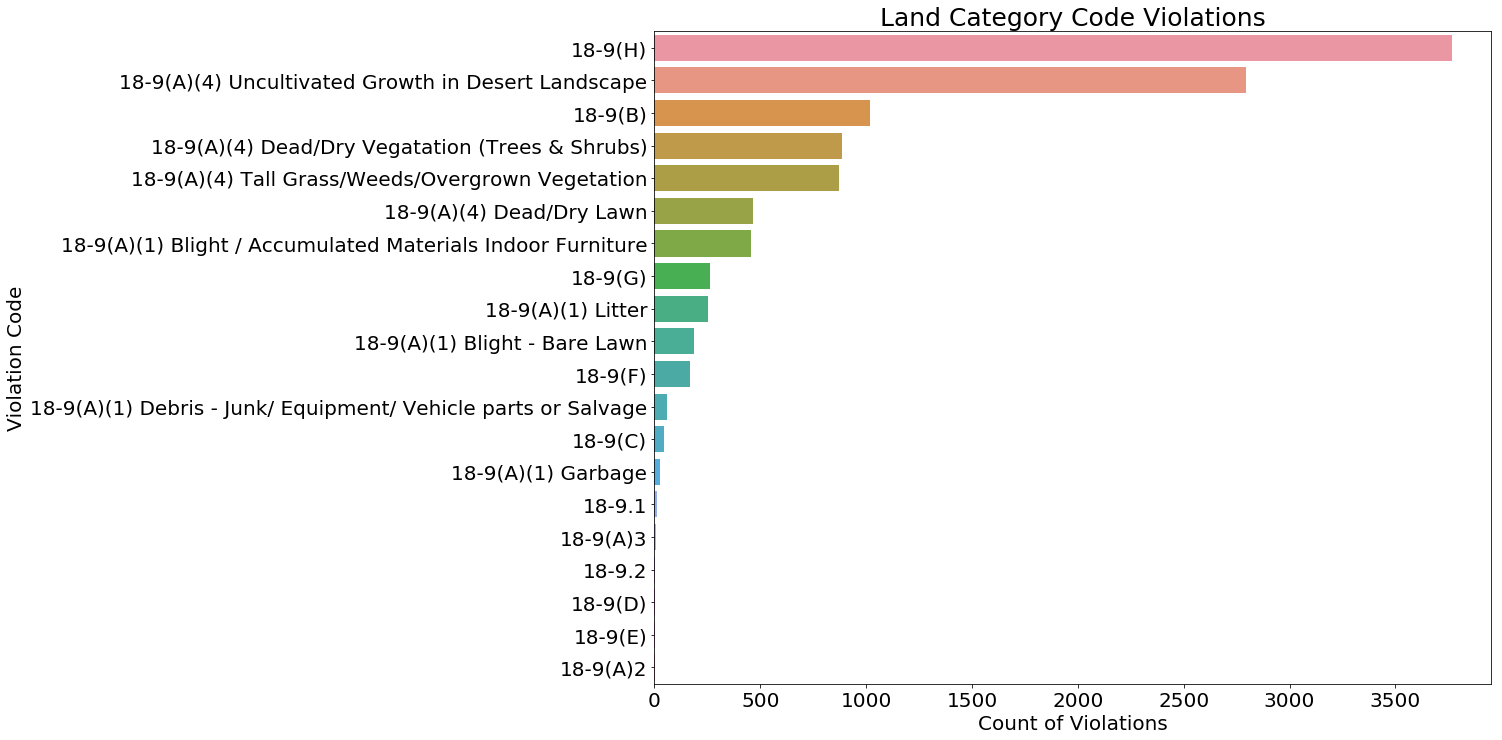

In [122]:
plt.rcParams["figure.figsize"] = [15, 12]

ax = sns.barplot(land_violations.values, land_violations.index)
plt.title('Land Category Code Violations',fontsize=25)
plt.ylabel('Violation Code',fontsize=20)
plt.xlabel('Count of Violations',fontsize=20)
plt.tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

In [128]:
# which code violations have the highest mean days before they are closed?
open_close_dif = code_violations.groupby('_ViolationCategory_')['Open_Close_Dif_Days'] \
    .mean() \
    .astype(int) \
    .sort_values(ascending=False) \
    .head(15)

open_close_dif

_ViolationCategory_
Zoning-Native Plant Program                                                                             138
Zoning-Article I ADMINISTRATION AND PROCEDURES: Sec. 1.400 CONDITIONAL USE PERMITS.                     116
Zoning-Uses Permitted Commercial                                                                        104
Zoning-Article VII General Provisions: Sec. 7.200 Additional Area Regulations                           101
18-110 UNIFORM HOUSING CODE SECTION 1001.8 FAULTY WEATHER PROTECTION                                     96
OTHER                                                                                                    95
Zoning-Development Review Board Approval                                                                 93
Zoning-Article V District Regulations: Sec. 5.100 R1-43 Single-Family Residential District               89
Development Review Board                                                                                 86
Zoning-A

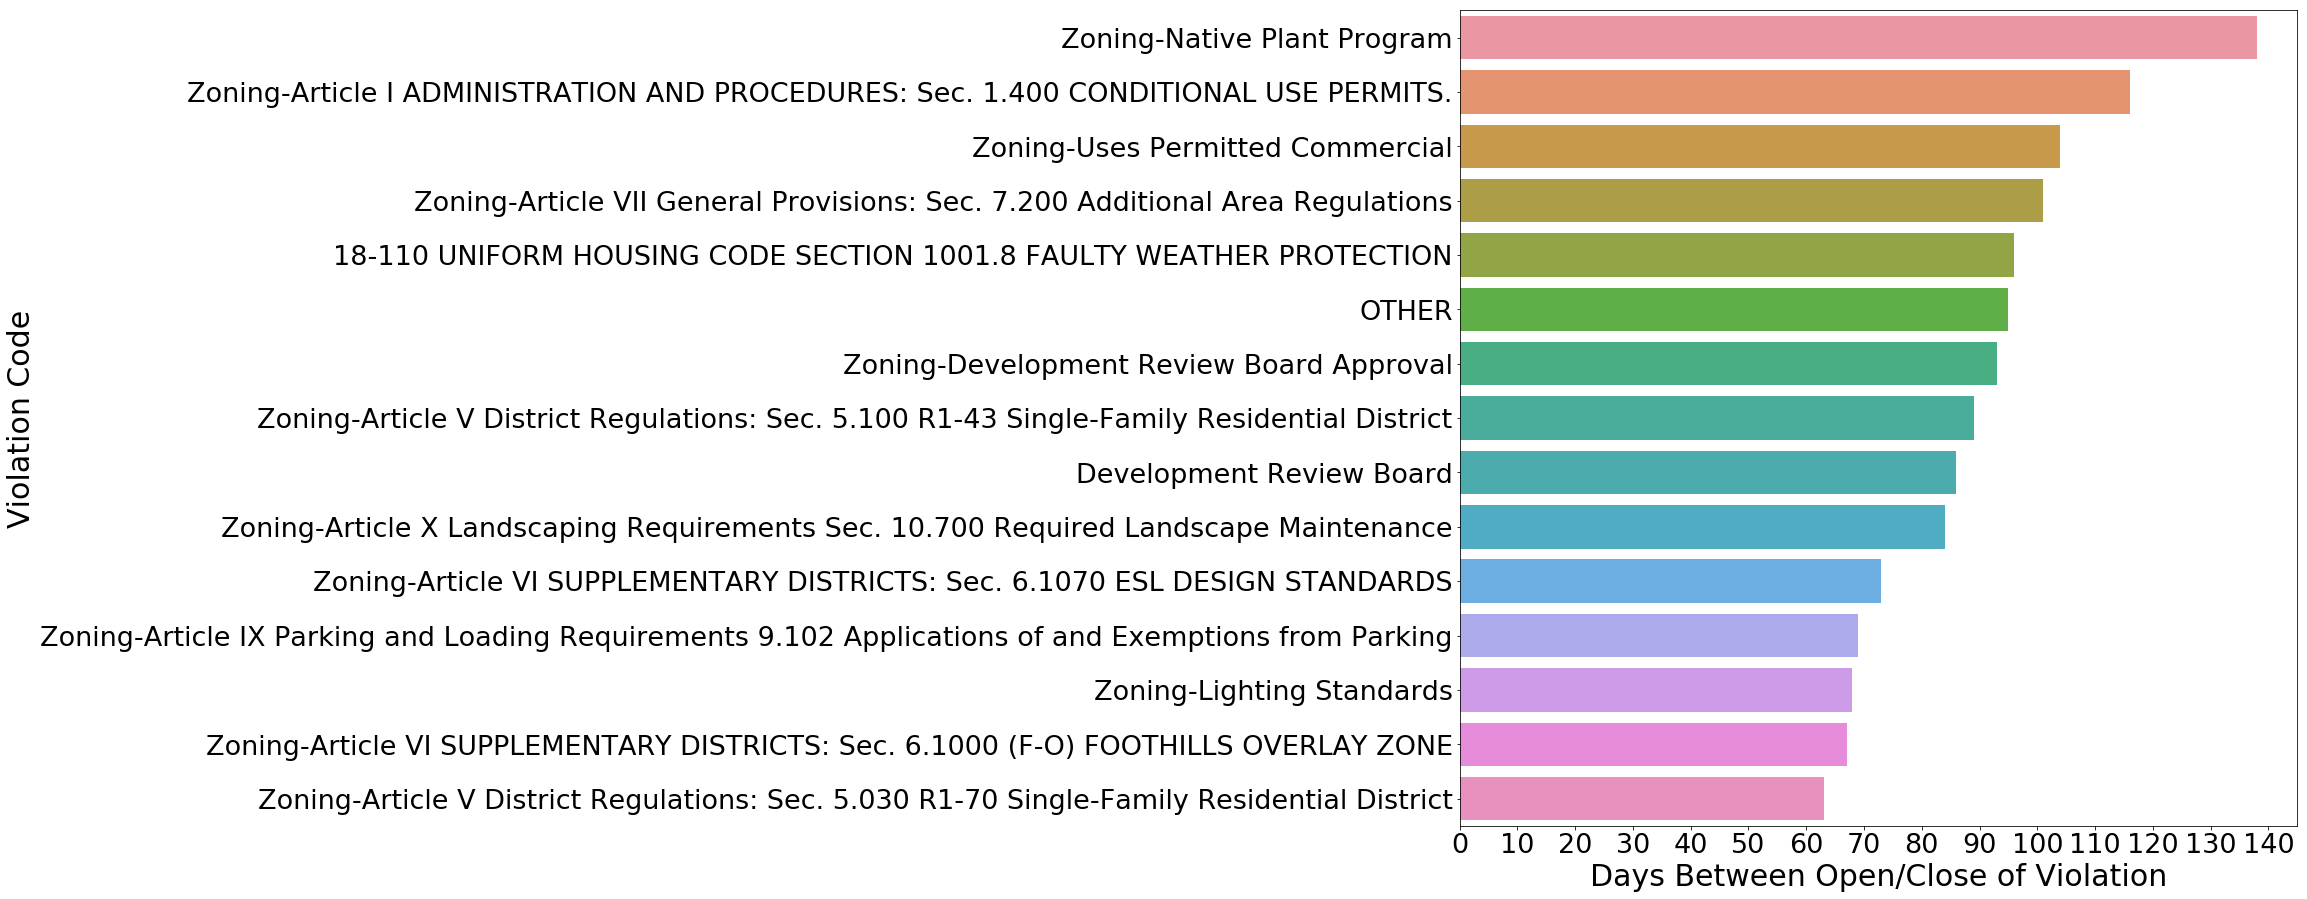

In [139]:
plt.rcParams["figure.figsize"] = [15, 15]

ax = sns.barplot(open_close_dif, open_close_dif.index)
plt.ylabel('Violation Code',fontsize=30)
plt.xlabel('Days Between Open/Close of Violation',fontsize=30)
plt.tick_params(labelsize=27)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))